# Why do we have so many VCI 1/100?

In [19]:
from pathlib import Path
import os
import warnings
from collections import namedtuple

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [5]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      '2020_04_28:143300_one_month_forecast_BASE_static_vars'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/2020_04_28:143300_one_month_forecast_BASE_static_vars


# Read in the data

In [6]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

# Why so many high/low VCI?

In [30]:
expected = 12 * ((ds.lat.shape[0] * ds.lon.shape[0]) - int(ds.boku_VCI.isel(time=0).isnull().sum().values))

print(f"Pixels: {(ds.lat.shape[0] * ds.lon.shape[0])}")
print(f"Non Nan Pixels: {(ds.lat.shape[0] * ds.lon.shape[0]) - int(ds.boku_VCI.isel(time=0).isnull().sum().values)}")
print(f"Times: {ds.time.shape[0]}")
print(f"Expected (1423 * 12): {expected}")

expected == 1423 * 12

Pixels: 1575
Non Nan Pixels: 1423
Times: 205
Expected (1423 * 12): 17076


True

In [25]:
from matplotlib import cm


def get_unique_value_counts_xarray(da: xr.Dataset, dropna: bool = True) -> Dict[int, int]:
    """ NOTE only works for int-like data! (e.g. whole floats)"""
    if dropna:
        data = da.values.flatten()
        data = data[~np.isnan(data)]
    else:
        data = da.values.flatten()
    counts = np.bincount(data.astype(int))
    ii = np.nonzero(counts)[0]
    
    return dict(zip(ii, counts[ii]))


def plot_unique_value_counts(da: xr.DataArray, ax: Optional = None, label: bool = True) -> plt.Axes:
    """"""
    # create count of unique values
    counts = get_unique_value_counts_xarray(da)
    d = pd.DataFrame(
        counts, index=[0]
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    n_unique_vals = len(counts)
    viridis = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))
    g = sns.barplot(data=d, palette=viridis, ax=ax)
    ax.set_ylabel('Number of Instances')
    ax.set_title('Count of Unique Values')
    
    if label:
        for p in g.patches:
            g.annotate(
                format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points'
            )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

## Plot unique values of VCI

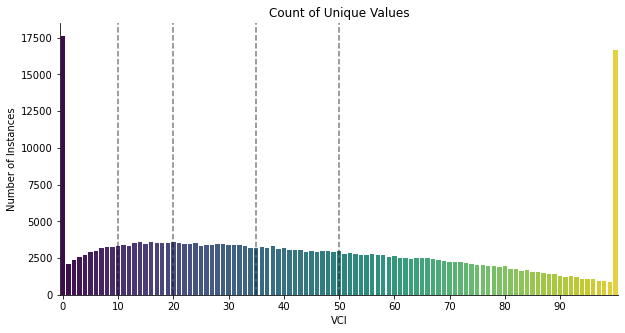

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_unique_value_counts(np.round(ds['boku_VCI']), label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

# What happens if we ignore extreme values?

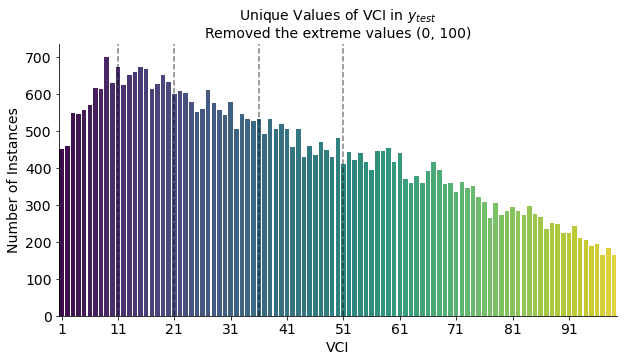

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

data = np.round(y_test['boku_VCI'])
data = np.round(y_test['boku_VCI']).where((np.round(y_test['boku_VCI']) != 100) & (np.round(y_test['boku_VCI']) != 0))
ax = plot_unique_value_counts(data, label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)
ax.set_title("Unique Values of VCI in $y_{test}$\nRemoved the extreme values (0, 100)")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

ax.set_xticks(np.arange(0, 99, 10))
ax.set_xticklabels(np.arange(1, 99, 10));

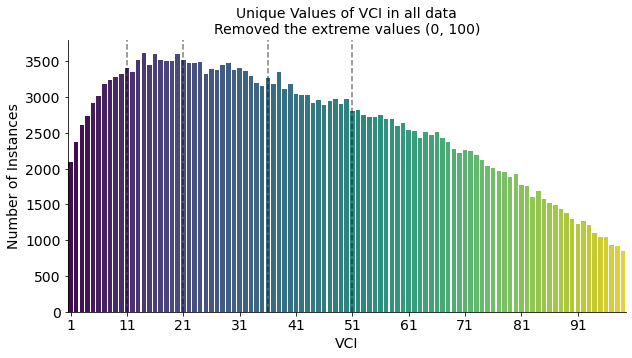

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

data = np.round(ds['boku_VCI'])
data = np.round(ds['boku_VCI']).where((np.round(ds['boku_VCI']) != 100) & (np.round(ds['boku_VCI']) != 0))
ax = plot_unique_value_counts(data, label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)
ax.set_title("Unique Values of VCI in all data\nRemoved the extreme values (0, 100)")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

ax.set_xticks(np.arange(0, 99, 10))
ax.set_xticklabels(np.arange(1, 99, 10));

# does our calculation of VCI make sense?